# Photometric stereo

In [1]:
from pyrt.math import Vec3
from pyrt.scene import Scene
from pyrt.light import PointLight
from pyrt.geometry import Sphere, Parallelogram
from pyrt.material import PhongMaterial
from pyrt.camera import PerspectiveCamera
from pyrt.renderer import SimpleRT
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

In this notebook we demonstrate the basic principle of photometric stereo with synthetic data.

## Image synthesis

We use ray tracing to create three images of a half sphere. The camera remains stationary between the images but the point light source is moved.

In [3]:
scene = Scene()
engine = SimpleRT(shadow=False, iterations=1)

# Creating Renderer: Simple Raytracer


In [4]:
width = 256
height = 256

In [5]:
camera = PerspectiveCamera(width, height, 40)
camera.setView(Vec3(1,-1,10), Vec3(0,0,0), Vec3(1.,0.,0.))
scene.setCamera(camera)

We use a light gray diffuse material without specularity for the background and the sphere.

In [6]:
material = PhongMaterial(color=Vec3(0.9,0.9,0.9), reflectivity=.0)

In [7]:
scene.add(Parallelogram(Vec3(-30,-30,0),Vec3(60,0,0),Vec3(0,60,0), material))
scene.add(Sphere(Vec3(0,0,0), 2, material))

We add a point light source to (5,-5,30), and render the image that is displayed below.

In [8]:
scene.addLight(PointLight(Vec3(5,-5,30)))

In [9]:
image1 = engine.render(scene)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 12.535550355911255s
NUMBER OF PRIMARY RAYS: 65536
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 5228.011386759409
##################################################


(-0.5, 255.5, 255.5, -0.5)

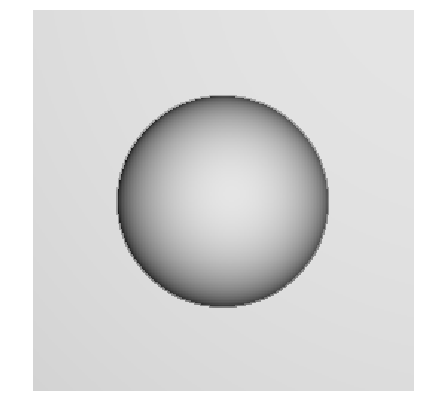

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(image1.data)
plt.axis('off')

Then we remove the light source and add another one to (2,6,30), and render again.

In [11]:
del scene.lights[0]
scene.addLight(PointLight(Vec3(2,6,30)))

In [12]:
image2 = engine.render(scene)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 12.579612493515015s
NUMBER OF PRIMARY RAYS: 65536
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 5209.699427051893
##################################################


(-0.5, 255.5, 255.5, -0.5)

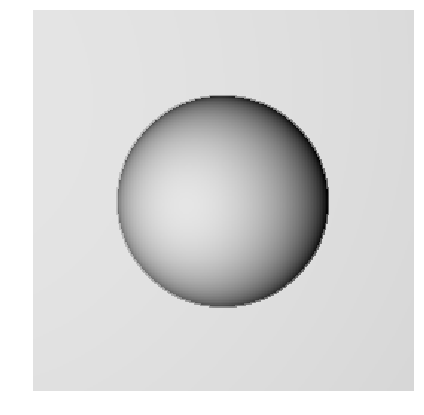

In [13]:
plt.figure(figsize=(7,7))
plt.imshow(image2.data)
plt.axis('off')

The same is repeated for the third image. The light source is placed to (8,-2,32).

In [14]:
del scene.lights[0]
scene.addLight(PointLight(Vec3(8,-2,32)))

In [15]:
image3 = engine.render(scene)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 12.601475954055786s
NUMBER OF PRIMARY RAYS: 65536
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 5200.660639986956
##################################################


(-0.5, 255.5, 255.5, -0.5)

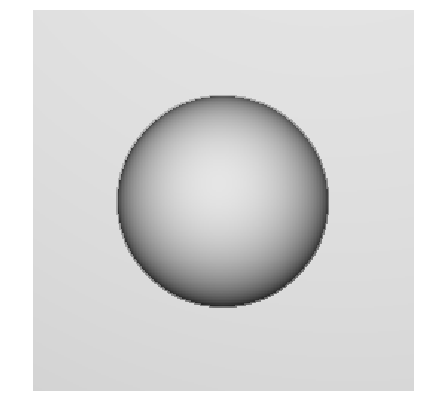

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(image3.data)
plt.axis('off')

## Algorithm
Next, we implement the photometric stereo algorithm presented in the lecture slides.

L1, L2, and L3 are vectors pointing to the light sources. They are normalized to unit length.

In [17]:
L1 = np.array([[5,-5,30]]).T
L2 = np.array([[2,6,30]]).T
L3 = np.array([[8,-2,32]]).T

In [18]:
L1 = L1/np.linalg.norm(L1)
L2 = L2/np.linalg.norm(L2)
L3 = L3/np.linalg.norm(L3)

A $3 \times 3$ inverse matrix $\mathbf{L}^{-1}$:

In [19]:
iL = np.linalg.inv(np.hstack((L1,L2,L3)))

An $m \times 3$ matrix $\mathbf{I}$ where $m$ is the number of pixels:

In [20]:
I1 = cv2.cvtColor(image1.data, cv2.COLOR_RGB2GRAY)
I2 = cv2.cvtColor(image2.data, cv2.COLOR_RGB2GRAY)
I3 = cv2.cvtColor(image3.data, cv2.COLOR_RGB2GRAY)
I1 = I1.reshape(-1,1)
I2 = I2.reshape(-1,1)
I3 = I3.reshape(-1,1)
I = np.hstack((I1, I2, I3))

Then we calculate the normal vectors for each pixel. As a result we get 3 images that contain the components of the normal vectors.

In [21]:
G = np.matmul(I, iL)
kd = np.linalg.norm(G, axis=1).reshape(-1,1)
N = G/(kd + 1e-10)

In [22]:
Ny = N[:,0].reshape(height,width)
Nx = N[:,1].reshape(height,width)
Nz = N[:,2].reshape(height,width)

## 3D reconstruction

We use a simple frequency domain approach explained in this [paper](http://vision.ucsd.edu/kriegman-grp/papers/eccv06c.pdf) for reconstructing the 3D surface from the normal vectors. The Fourier transform of the 3D surface is

$G(\omega_x,\omega_y) = \frac{j \omega_x F_x(\omega_x,\omega_y) + j \omega_y F_y(\omega_x,\omega_y)}{\omega_x^2 + \omega_y^2}$

where $F_x$ and $F_y$ are the Fourier transforms of $N_x/N_z$ and $N_y/N_z$.

In [23]:
nx = Nx/(Nz+1e-10)
ny = Ny/(Nz+1e-10)

In [24]:
Fx=np.fft.fft2(nx)
Fy=np.fft.fft2(ny)

In [25]:
ax = (np.mod(np.arange(0,width)/width*2+1,2)-1)*np.pi
ay = (np.mod(np.arange(0,height)/height*2+1,2)-1)*np.pi
ox, oy = np.meshgrid(ax,ay)   #Angular frequency grid

In [26]:
G = 1j*(ox*Fx+oy*Fy)/(ox**2+oy**2+1e-10)

In [27]:
Rec = np.real(np.fft.ifft2(G))

As a result we get a depth map that is visualized below as a grayscale image and a 3D surface.

(-0.5, 255.5, 255.5, -0.5)

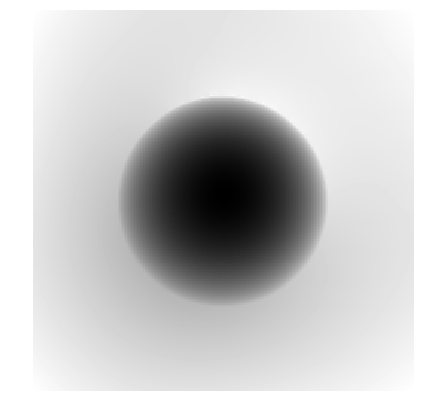

In [28]:
plt.figure(figsize=(7,7))
plt.imshow(Rec,cmap='gray')
plt.axis('off')

(-20, 100)

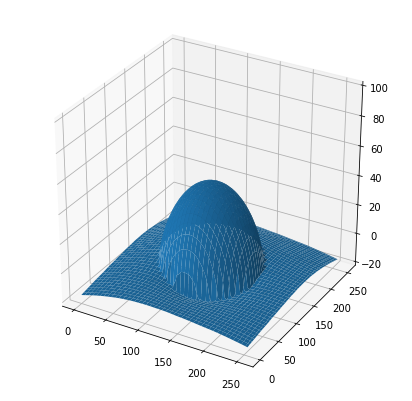

In [29]:
x, y = np.meshgrid(range(width),range(height))
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,-Rec)
ax.set_zlim3d([-20, 100])

We can see some distortion caused by the assumption that the light rays are parallel while in reality they are not.